In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype

import seaborn as sns
from scipy.io import loadmat,savemat
from scipy.signal import deconvolve, savgol_filter

import os
os.environ['R_HOME'] = 'C:\\Users\\j_gav\\anaconda3\\envs\\analysis\\lib\\R'

from plotnine import *

from scipy.spatial import KDTree
from scipy.ndimage.interpolation import shift

from utils import *

from pymer4 import Lmer, Lm

savepath = './figures/'



In [6]:
# Whether baseline is early (RP-based analyses) or right before probe (post-probe analyses)
post = False

if post:
    df = pd.read_csv('./data/df_Long_rebaselined.csv')
else:
    df = pd.read_csv('./data/df_Long.csv')
df_b = pd.read_csv('./data/df_b_long.csv') # behavior

In [7]:
# we've already inspected which electrodes to use for RP analysis -- use these here

locs_to_use = {
    "33702":'cz',
    "33703":'cz',
    "33704":'fcz',
    "33705":'cz',
    "33706":'cz',
    "33707":'na',
    
    "33708":'fz',
    "33709":'cz',
    "33710":'cz',
    "33711":'cz',
    "33712":'cz',
    "33713":'fcz',
    
    "33714":'fcz',
    "33715":'fcz',
    "33716":'fz',
    "33717":'fcz',
    "33718":'fcz',
    "33719":'cz',
    
    "33720":'fcz',
    "33721":'na',
    "33722":'na',
    "33723":'fcz',
    "33724":'na',
    "33725":'fcz'
}

df['rp'] = df['cz_base']
for sub_id in locs_to_use.keys():
    if locs_to_use[sub_id] == 'na':
        df.loc[df.subject == int(sub_id),'rp'] = np.nan
    else:    
        df.loc[df.subject== int(sub_id),'rp'] = df.loc[df.subject == int(sub_id),f"{locs_to_use[sub_id]}_base"]

## Run this if you want to re-do the LME fitting of the ERPs, otherwise skip to next section

In [8]:
fti_mask = np.logical_or((df.fti_time.values <=0.2), (df.condition.isin(['RP','Hit','Miss'])))


df_temp = df[(fti_mask) &
             (~df.subject.isin([33721]))]

frames = []
frames_sig = []
for time in df.time.unique():
    df_t = df_temp[(df_temp.time == time) & (df_temp.condition.isin(['Hit','Miss','FTI','RP']))]
    
    
    
    model = Lmer('rp ~ condition + (1|subject)',data=df_t)
    
    model.fit(factors = {'condition':['Hit','Miss','FTI','RP']},summary=False)
    
    
    marginal_estimates, comparisons = model.post_hoc(
        marginal_vars="condition",#, grouping_vars=["precueType"],
        p_adjust = "bonf"
    )
#     df_t = model.coefs.copy()
    df_t = marginal_estimates.copy()    
    
    df_t['time'] = time
    frames.append(df_t)
    
    df_t = comparisons.copy()
    df_t['time'] = time
    frames_sig.append(df_t)
    
    
df_CI = pd.concat(frames)
df_sig = pd.concat(frames_sig).reset_index()
df_CI = df_CI.reset_index()

df_CI = df_CI.rename(columns = {'2.5_ci':'ci_low','97.5_ci':'ci_high'})

if post:
    df_CI.to_csv('./data/df_CI_rebaselined.csv',index=False)
    df_sig.to_csv('./data/df_sig_rebaselined.csv',index=False)
else:
    df_CI.to_csv('./data/df_CI.csv',index=False)
    df_sig.to_csv('./data/df_sig.csv',index=False)

## Plotting of fitted ERP grand-averages

### Figure 3A - Grand-Average ERPs for all four main conditions

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 241 rows containing missing values.


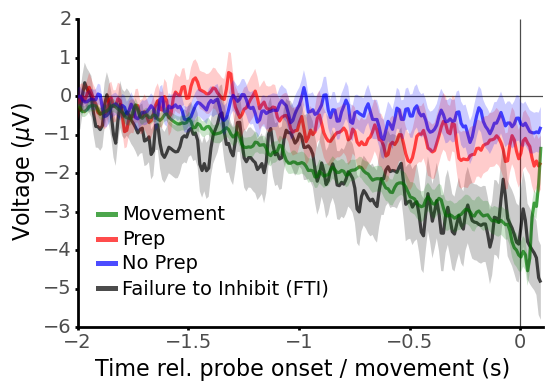

<ggplot: (172584593439)>

In [16]:
df_CI = pd.read_csv('./data/df_CI.csv')
df_sig = pd.read_csv('./data/df_sig.csv')

df_temp = df_CI.reset_index().copy()

df_temp = df_temp.rename(columns = {'Unnamed: 0':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

# df_temp = df_temp[df_temp.condition.isin(['conditionFTI','conditionMiss','conditionHit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values

df_tsig = df_CI.reset_index().copy()

df_tsig['yintercept1'] = 1.
df_tsig['yintercept2'] = 1.2
df_tsig['yintercept3'] = 1.4
df_tsig['yintercept4'] = 1.6


df_tsig['sig'] = (df_tsig['ci_high'].values < 0.).astype('int') # 6 bonferroni post-hoc test correction = 0.01 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan


p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
      geom_hline(yintercept=0,linetype='-',color='black',alpha=0.7) +
   geom_vline(xintercept=0,linetype='-',color='black',alpha=0.7) + 

geom_line(alpha=0.7,size=1.3) + 
   geom_ribbon(alpha=0.2,color='none',show_legend=False) +
#    geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.condition.isin(['RP'])) & (df_tsig.sig == 1)],color='green',fill='green') +
#    geom_point(aes(y = 'yintercept2'),data = df_tsig[(df_tsig.condition.isin(['FTI'])) & (df_tsig.sig == 1)],color='black',fill='black') +
#     geom_point(aes(y = 'yintercept3'),data = df_tsig[(df_tsig.condition.isin(['Hit'])) & (df_tsig.sig == 1)],color='red',fill='red') +
#    geom_point(aes(y = 'yintercept4'),data = df_tsig[(df_tsig.condition.isin(['Miss'])) & (df_tsig.sig == 1)],color='blue',fill='blue') +
   

 scale_x_continuous(name='Time rel. probe onset / movement (s)',breaks=np.arange(-2.5,0.9,0.5),limits=(-2,0.1),expand = (0,0)) +
   scale_y_continuous(name='Voltage ($\mu$V)',breaks=np.arange(-12.,12.6,1),limits=(-6.,2),expand = (0,0)) +
   scale_color_manual(breaks = ['RP','Hit','Miss','FTI'],
                        labels = ['Movement','Prep','No Prep','Failure to Inhibit (FTI)'],
                      values=['green','red','blue','black'])+
   scale_fill_manual(breaks = ['RP','Hit','Miss','FTI'],values=['green','red','blue','black']) +
 theme_classic() +
   theme(legend_position=(0.35,0.3),
        legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (6,4)) 
)

# p.save(savepath+'ERP/allconds_CI_zoom_deltazero.svg')
# p.save(savepath+'ERP/allconds_CI_zoom_deltazero.png')

p

### Figure 3B: Amplitude in 250 ms prior to probe/movement

In [ ]:
## Error Bars Only
df_temp = df[(df.time >= -0.25) & (df.time <= 0.0) & (df.condition.isin(['Hit','Miss','FTI','RP'])) & (~df.subject.isin(['33721','33707','33722','33724']))].copy()
df_temp = df_temp.groupby(['subject','condition','trial'],as_index=False).mean()
df_temp['subject'] = df_temp.subject.astype('str')
df_temp.to_csv('processed_data/rp_mainconds.csv',index=False)
model = Lmer('rp~condition+(1|subject)',data=df_temp)

model.fit(factors={'condition':['Miss','Hit','RP','FTI']},summary=False)

marginal_estimates, comparisons = model.post_hoc(
    marginal_vars="condition",p_adjust='tukey'#, grouping_vars=["precueType"]
)
print(comparisons)

df2use = marginal_estimates.copy()

df2use.rename({'2.5_ci':'CIlow','97.5_ci':'CIhigh'},axis=1,inplace=True)

p = (ggplot(df2use,aes(x='condition',y='Estimate',color='condition',fill='condition',ymin='CIlow',ymax='CIhigh')) +
     scale_x_discrete(name='Condition',limits=['Miss','Hit','FTI','RP'],labels=['No Prep','Prep','FTI','Move.']) +
     geom_errorbar(size=2,width=0.2) +
     geom_point(size=3) +
   scale_y_continuous(name='Voltage ($\mu$V)',limits=(-5,3),breaks=np.arange(-10,10,1),expand=(0,0)) +
   scale_color_manual(name='Condition',values=['gray','#FF3838','#00E3F7','green'])+
     scale_fill_manual(values=['gray','#FF3838','#00E3F7','green']) +
#  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position='none',
        axis_text_y = element_text(size=18),
     axis_text_x = element_text(size=16),

       axis_ticks_length = 2,
       axis_title_y = element_text(size=16),
         axis_title_x = element_blank(),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (4,4)) 
)

# p.save(savepath+'ERP/LME_amplitudes_errbar_all.svg')
# p.save(savepath+'ERP/LME_amplitudes_errbar_all.png')

p

#### Additional: fitting slopes on activity 1 second before probe onset for Prep, No Prep, and FTI trials

In [ ]:
# Time-dependent, rather than just taking the average amplitude in the 500 ms before probe
df_temp = df[(df.time >= -1) & (df.time <= 0.) & (df.condition.isin(['Hit','Miss','FTI'])) & (~df.subject.isin(['33721','33707','33722','33724']))].copy()
df_temp = df_temp.groupby(['subject','condition','trial','time'],as_index=False).mean()
df_temp['subject'] = df_temp.subject.astype('str')

# Set up model so that it is an effect of condition and a random intercept of subject
model = Lmer('rp ~ time*condition + (condition|subject)',data=df_temp)

#     print(model.fit())
print(model.fit(factors={"condition":['Miss','Hit','FTI']}))


fig = plt.figure(figsize=(10,20))

model.plot_summary(plot_intercept=False)

# plt.savefig(savepath+'/lme_probe_eeg_pre.eps')

### Unused Figure 3: Grand averaged ERPs for Prep, No Prep, and FTI separate

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 241 rows containing missing values.


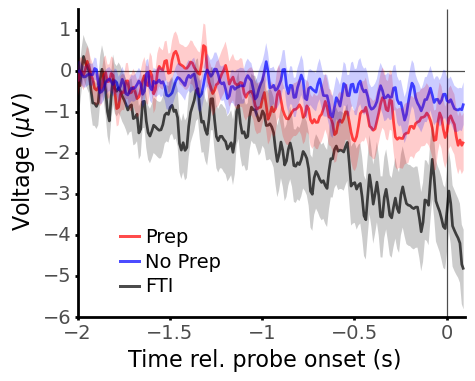

<ggplot: (172584670434)>

In [17]:
df_CI = pd.read_csv('./data/df_CI.csv')
df_sig = pd.read_csv('./data/df_sig.csv')

df_temp = df_CI.reset_index()

df_temp = df_temp.rename(columns = {'Unnamed: 0.1':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

df_temp = df_temp[df_temp.condition.isin(['FTI','Miss','Hit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values

# df_temp = df_temp[['time','eeg_base','condition']]

df_tsig = df_sig.copy()

df_tsig['yintercept1'] = 1
df_tsig['yintercept2'] = 1.2
df_tsig['yintercept3'] = 1.4

df_tsig['sig'] = (df_tsig['P-val'].values < 0.3).astype('int') # 6 bonferroni post-hoc test correction = 0.01 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan
df_tsig['condition'] = np.nan

p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
      geom_hline(yintercept=0,linetype='-',color='black',alpha=0.7) +
   geom_vline(xintercept=0,linetype='-',color='black',alpha=0.7) + 

geom_line(alpha=0.7,size=1.1) + 
      geom_ribbon(alpha=0.2,color='none',show_legend=False) +
#    geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - Miss'])) & (df_tsig.sig == 1)],color='magenta',fill='magenta') +
#    geom_point(aes(y = 'yintercept2'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - FTI'])) & (df_tsig.sig == 1)],color='red',fill='red') +
#     geom_point(aes(y = 'yintercept3'),data = df_tsig[(df_tsig.Contrast.isin(['Miss - FTI'])) & (df_tsig.sig == 1)],color='blue',fill='blue') +

 scale_x_continuous(name='Time rel. probe onset (s)',
                    breaks=np.arange(-2.5,1.6,0.5),
                    limits=(-2,0.1),
                    expand = (0,0)) +
   scale_y_continuous(name='Voltage ($\mu$V)',
                      breaks=np.arange(-7,5,1),
                      limits=(-6,1.5),
                      expand = (0,0)) +
scale_color_manual(breaks = ['Hit','Miss','FTI'],
                        labels = ['Prep','No Prep','FTI'],
                      values=['red','blue','black'])+
   scale_fill_manual(breaks = ['Hit','Miss','FTI'],values=['red','blue','black']) +
# #  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position=(0.31,0.25),
         legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (5,4)) 
)

# p.save(savepath+'ERP/probe_separate_CI.svg')
# p.save(savepath+'ERP/probe_separate_CI.png')

p

### Figure 3C: ERP traces when Prep and FTI trials are grouped together

#### Code for doing this analysis -- skip if you want to just plot the data

In [6]:
fti_mask = np.logical_or((df.fti_time.values <=0.2), (df.condition.isin(['RP','Hit','Miss'])))


df_temp = df[(fti_mask) &
             (~df.subject.isin([33721]))].copy()

df_temp.loc[df_temp.condition.str.match('FTI'),'condition'] = 'Hit'

df_temp.condition.unique()

frames = []
frames_sig = []
for time in df.time.unique():
    df_t = df_temp[(df_temp.time == time) & (df_temp.condition.isin(['Hit','Miss','FTI','RP']))]
    
    
    
    model = Lmer('rp ~ condition + (1|subject)',data=df_t)
    
    model.fit(factors = {'condition':['Hit','Miss','RP']},summary=False)
    
    
    marginal_estimates, comparisons = model.post_hoc(
        marginal_vars="condition",#, grouping_vars=["precueType"],
        p_adjust = "bonf"
    )
#     df_t = model.coefs.copy()
    df_t = marginal_estimates.copy()    
    
    df_t['time'] = time
    frames.append(df_t)
    
    df_t = comparisons.copy()
    df_t['time'] = time
    frames_sig.append(df_t)
    
 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by bonf method for 3 comparisons
**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by bonf method for 3 comparisons
boundary (singular) fit: see help('isSingular') 

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your 

In [7]:
df_CI_together = pd.concat(frames).reset_index()
df_sig_together = pd.concat(frames_sig).reset_index()
    
df_CI_together.to_csv('../processed_data/df_CI_together.csv',index=False)
df_sig_together.to_csv('../processed_data/df_sig_together.csv',index=False)

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 241 rows containing missing values.


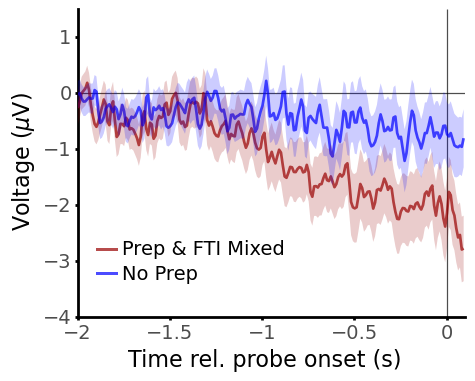

<ggplot: (172584759065)>

In [19]:
df_CI_together = pd.read_csv('./data/df_CI_together.csv')
df_sig_together = pd.read_csv('./data/df_sig_together.csv')


df_temp = df_CI_together.reset_index()

df_temp = df_temp.rename(columns = {'Unnamed: 0':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

df_temp = df_temp[df_temp.condition.isin(['FTI','Miss','Hit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values


# df_temp = df_temp[['time','eeg_base','condition']]
df_tsig = df_sig_together.copy()

df_tsig['yintercept1'] = 0.6

df_tsig['sig'] = (df_tsig['P-val'].values < 0.15).astype('int') # 6 bonferroni post-hoc test correction = 0.01 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan
df_tsig['condition'] = np.nan

p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
      geom_hline(yintercept=0,linetype='-',color='black',alpha=0.7) +
   geom_vline(xintercept=0,linetype='-',color='black',alpha=0.7) + 

geom_line(alpha=0.7,size=1.1) + 
      geom_ribbon(alpha=0.2,color='none',show_legend=False) +
#     geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - Miss'])) & (df_tsig.sig == 1)],color='magenta',fill='magenta') +
 scale_x_continuous(name='Time rel. probe onset (s)',
                    breaks=np.arange(-2.5,1.6,0.5),
                    limits=(-2,0.1),
                    expand = (0,0)) +
   scale_y_continuous(name='Voltage ($\mu$V)',
                      breaks=np.arange(-7,5,1),
                      limits=(-4,1.5),
                      expand = (0,0)) +
   scale_color_manual(breaks = ['Hit','Miss'],
                      labels = ['Prep & FTI Mixed','No Prep'],
                      values=['#990000','blue'])+
      scale_fill_manual(breaks = ['Hit','Miss'],values=['#990000','blue']) +

#  labs(title='Anticipatory Pupil Dilations') +
   theme_classic() +
 theme(legend_position=(0.35,0.25),
         legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
       axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (5,4)) 
)

# p.save(savepath+'ERP/probe_together_CI.svg')
# p.save(savepath+'ERP/probe_together_CI.png')

p

### Figure 3D: Post-Probe ERPs

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 361 rows containing missing values.


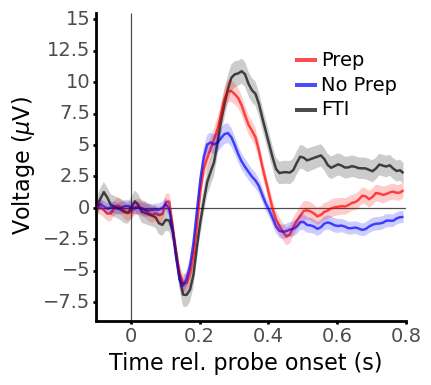

<ggplot: (172576613355)>

In [21]:
# Subjects w/ less than 10 hit trials: 33702, 33703, 33712, 33718, 33720, 33725
# Subjects w/ upwards-trending: 33721, 33708, 33713, 33715, 33724, 33725, 33716

df_CI = pd.read_csv('./data/df_CI_rebaselined.csv')
df_sig = pd.read_csv('./data/df_sig_rebaselined.csv')

df_temp = df_CI.reset_index()

df_temp = df_temp.rename(columns = {'2.5_ci':'ci_low','97.5_ci':'ci_high'})

df_temp = df_temp[df_temp.condition.isin(['FTI','Miss','Hit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values


df_tsig = df_sig.copy()




p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
         geom_hline(yintercept=0,linetype='-',color='black',alpha=0.7) +
   geom_vline(xintercept=0,linetype='-',color='black',alpha=0.7) + 

geom_line(alpha=0.7,size=1.) + 
   geom_ribbon(alpha=0.2,color='none',show_legend=False) +
 scale_x_continuous(name='Time rel. probe onset (s)',breaks=np.arange(0,1,0.2),limits=(-0.1,0.8),expand = (0,0)) +
   scale_y_continuous(name='Voltage ($\mu$V)',breaks=np.arange(-12.5,15.25,2.5),limits=(-9,15.5),expand = (0,0)) +
   scale_color_manual(breaks = ['Hit','Miss','FTI'],
                        labels = ['Prep','No Prep','FTI'],
                      values=['red','blue','black'])+
   scale_fill_manual(breaks = ['Hit','Miss','FTI'],values=['red','blue','black']) +
 theme_classic() +
   theme(legend_position=(0.75,0.7),
        legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
        figure_size = (4,4)) 
)

# p.save(savepath+'ERP/postprobe_CI_nosig.svg')
# p.save(savepath+'ERP/postprobe_CI_nosig.png')

p

## Supplementary ERP figures

### Repeating analysis while restricting subjects based on certain behavioral criteria

Some subjects were probed as few as 15% of the time, and some (accordingly) had very few trials where they reported preparation or no preparation.
What we'll do is restrict the subjects and conduct the same analyses (see below), based on the two following criteria

1. At least 10 hit & miss trials each
2. Within 15% of 50% probe/movement ratio

In [25]:
df_temp = df.groupby(['subject','condition','trial'],as_index=False).mean()

for subject in df_temp.subject.unique():
    
    df_this = df_temp[df_temp.subject == subject]
    
    
    print(f"Subject {subject} has {np.sum(df_this.condition.isin(['Hit']).values)} Prep. trials and {np.sum(df_this.condition.isin(['Miss']).values)} No Prep. trials")
    print(f"Subject {subject} has {np.mean(df_this.isprobe.values)} frequency of probe trials")
        
        
        

Subject 33702 has 3 Prep. trials and 13 No Prep. trials
Subject 33702 has 0.3161290322580645 frequency of probe trials
Subject 33703 has 0 Prep. trials and 2 No Prep. trials
Subject 33703 has 0.271523178807947 frequency of probe trials
Subject 33704 has 15 Prep. trials and 58 No Prep. trials
Subject 33704 has 0.5634517766497462 frequency of probe trials
Subject 33705 has 34 Prep. trials and 53 No Prep. trials
Subject 33705 has 0.4898989898989899 frequency of probe trials
Subject 33706 has 25 Prep. trials and 57 No Prep. trials
Subject 33706 has 0.6130653266331658 frequency of probe trials
Subject 33707 has 36 Prep. trials and 45 No Prep. trials
Subject 33707 has 0.48 frequency of probe trials
Subject 33708 has 21 Prep. trials and 2 No Prep. trials
Subject 33708 has 0.14507772020725387 frequency of probe trials
Subject 33709 has 22 Prep. trials and 30 No Prep. trials
Subject 33709 has 0.43386243386243384 frequency of probe trials
Subject 33710 has 27 Prep. trials and 18 No Prep. trials


In [26]:
df_temp = df.groupby(['subject','condition','trial'],as_index=False).mean()

hit_cutoff = 10
miss_cutoff = 10

dist_from_50 = 0.15

bad4conds = []
bad4probefreq= []

for subject in df_temp.subject.unique():
    
    df_this = df_temp[df_temp.subject == subject]
    
    good4conds_this = (np.sum(df_this.condition.isin(['Hit']).values) > hit_cutoff) & (np.sum(df_this.condition.isin(['Miss']).values) > miss_cutoff)
    good4probefreq_this = np.abs(np.mean(df_this.isprobe.values) - 0.5) < dist_from_50
    print(f"Subject {subject} good for Hit/Miss? {good4conds_this}, good for probe freq? {good4probefreq_this}")
    
    if ~good4conds_this: 
        bad4conds.append(subject)
    if ~good4probefreq_this:
        bad4probefreq.append(subject)

Subject 33702 good for Hit/Miss? False, good for probe freq? False
Subject 33703 good for Hit/Miss? False, good for probe freq? False
Subject 33704 good for Hit/Miss? True, good for probe freq? True
Subject 33705 good for Hit/Miss? True, good for probe freq? True
Subject 33706 good for Hit/Miss? True, good for probe freq? True
Subject 33707 good for Hit/Miss? True, good for probe freq? True
Subject 33708 good for Hit/Miss? False, good for probe freq? False
Subject 33709 good for Hit/Miss? True, good for probe freq? True
Subject 33710 good for Hit/Miss? True, good for probe freq? False
Subject 33711 good for Hit/Miss? True, good for probe freq? True
Subject 33712 good for Hit/Miss? False, good for probe freq? True
Subject 33713 good for Hit/Miss? True, good for probe freq? True
Subject 33714 good for Hit/Miss? True, good for probe freq? True
Subject 33715 good for Hit/Miss? True, good for probe freq? False
Subject 33716 good for Hit/Miss? False, good for probe freq? False
Subject 33717 

In [27]:
fti_mask = np.logical_or((df.fti_time.values <=0.2), (df.condition.isin(['RP','Hit','Miss'])))


df_temp = df[(fti_mask) &
             (~df.subject.isin([33721]+bad4conds))]

frames = []
frames_sig = []
for time in df.time.unique():
    df_t = df_temp[(df_temp.time == time) & (df_temp.condition.isin(['Hit','Miss','FTI','RP']))]
    
    
    
    model = Lmer('rp ~ condition + (1|subject)',data=df_t)
    
    model.fit(factors = {'condition':['Hit','Miss','FTI','RP']},summary=False)
    
    
    marginal_estimates, comparisons = model.post_hoc(
        marginal_vars="condition",#, grouping_vars=["precueType"],
        p_adjust = "bonf"
    )
#     df_t = model.coefs.copy()
    df_t = marginal_estimates.copy()    
    
    df_t['time'] = time
    frames.append(df_t)
    
    df_t = comparisons.copy()
    df_t['time'] = time
    frames_sig.append(df_t)
    
    
df_CI = pd.concat(frames)
df_sig = pd.concat(frames_sig).reset_index()
df_CI = df_CI.reset_index()

df_CI = df_CI.rename(columns = {'2.5_ci':'ci_low','97.5_ci':'ci_high'})

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by bonf method for 6 comparisons
**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by bonf method for 6 comparisons
**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

P-values adjusted by bonf method for 6 comp


KeyboardInterrupt



In [ ]:
df_temp = df_CI.reset_index().copy()

df_temp = df_temp.rename(columns = {'Unnamed: 0':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

# df_temp = df_temp[df_temp.condition.isin(['conditionFTI','conditionMiss','conditionHit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values

df_tsig = df_sig.copy()

df_tsig['yintercept1'] = 1.
df_tsig['yintercept2'] = 1.25
df_tsig['yintercept3'] = 1.5

df_tsig['sig'] = (df_tsig['P-val'].values < 0.3).astype('int') # 6 bonferroni post-hoc test correction = 0.01 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan
df_tsig['condition'] = np.nan


p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
geom_line(alpha=0.7,size=1.3) + 
   geom_ribbon(alpha=0.2,color='none',show_legend=False) +
   geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - Miss'])) & (df_tsig.sig == 1)],color='magenta',fill='magenta') +
   geom_point(aes(y = 'yintercept2'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - FTI'])) & (df_tsig.sig == 1)],color='red',fill='red') +
    geom_point(aes(y = 'yintercept3'),data = df_tsig[(df_tsig.Contrast.isin(['Miss - FTI'])) & (df_tsig.sig == 1)],color='blue',fill='blue') +

 scale_x_continuous(name='Time rel. probe onset / movement (s)',breaks=np.arange(-2.5,0.9,0.5),limits=(-2,0.1),expand = (0,0)) +
   scale_y_continuous(name='Voltage ($\mu$V)',breaks=np.arange(-12.,12.6,1),limits=(-6.,2),expand = (0,0)) +
   scale_color_manual(breaks = ['RP','Hit','Miss','FTI'],
                        labels = ['Movement','Prep.','No Prep.','Failure to Inhibit (FTI)'],
                      values=['green','red','blue','black'])+
   scale_fill_manual(breaks = ['RP','Hit','Miss','FTI'],values=['green','red','blue','black']) +
 theme_classic() +
   theme(legend_position=(0.35,0.25),
        legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=12),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         
        figure_size = (6,4)) +
   geom_vline(xintercept=0,linetype='--',color='black') + 
   geom_hline(yintercept=0,linetype='--',color='black') 
)

# p.save(savepath+'ERP/remove_conds_allconds_CI_zoom.svg')
# p.save(savepath+'ERP/remove_conds_allconds_CI_zoom.png')

p

### RPs from all subjects

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 101 rows containing missing values.


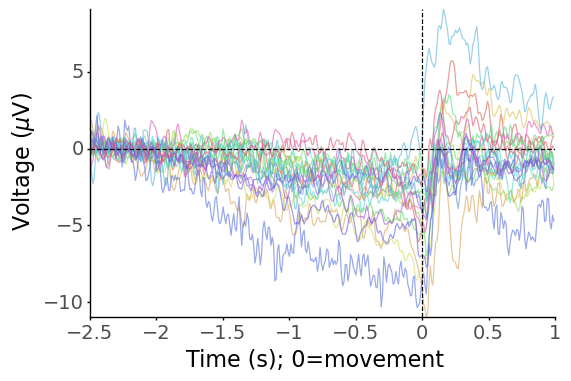

<ggplot: (172574578038)>

In [8]:
# Show RPs from all subjects -- supplementary figure

df_temp = df[(df.wait_time > 2.5) & (df.condition.str.match('RP'))].groupby(['time','subject'],as_index=False).mean()
df_temp['subject'] = df_temp.subject.values.astype('str')
p=(ggplot(df_temp,aes(x='time',y='rp',color='subject')) +
geom_line(alpha=0.6,) + 
 scale_x_continuous(name='Time (s); 0=movement',breaks=np.arange(-2.5,1.6,0.5),limits=(-2.5,1),expand=(0,0)) +
#  scale_y_continuous(breaks=np.arange(-15,36,5),limits=(-15,38)) +
   scale_y_continuous(name='Voltage ($\mu$V)',expand=(0,0)) +
   theme_classic() +
   theme(legend_position='none',
        axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
        figure_size = (6,4)) +
   geom_vline(xintercept=0,linetype='--',color='black') + 
   geom_hline(yintercept=0,linetype='--',color='black') 
)



# p.save(savepath+'ERP/supp_rp_bysub.svg')
# p.save(savepath+'ERP/supp_rp_bysub.png')

p

### Comparison of RP from short & long waiting times

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 201 rows containing missing values.


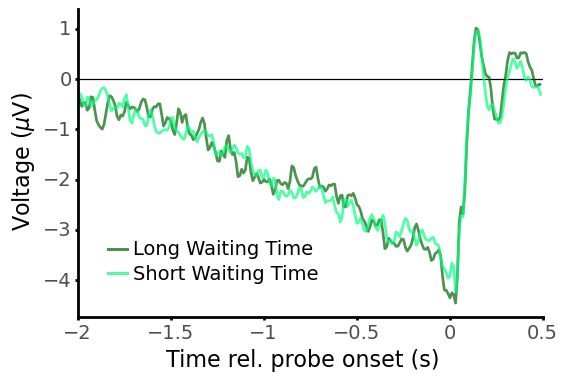

<ggplot: (172584464210)>

In [28]:
df_temp = df[(df.wait_time > 2.5) & (df.condition.isin(['RP'])) ]
df_temp = df_temp.groupby(['time','subject','brief'],as_index=False).mean().groupby(['time','brief'],as_index=False).mean()
df_temp['brief'] = df_temp.brief.values.astype('str')

df_temp['size_base'] = df_temp['size_base']

# Plot all the dilations by subject
p=(ggplot(df_temp,aes(x='time',y='rp',color='brief')) +
    geom_hline(yintercept=0,linetype='-',color='black') +


    geom_line(alpha=0.7,size=1.1,) + 
     scale_x_continuous(name='Time rel. probe onset (s)',
                    breaks=np.arange(-2.5,1.6,0.5),
                    limits=(-2,0.5),
                    expand = (0,0)) +
     scale_color_manual(name='Wait Time',values=['darkgreen','springgreen'],labels=['Long Waiting Time','Short Waiting Time'])+

   scale_y_continuous(name='Voltage ($\mu$V)')+
   theme_classic() +
   theme(legend_position=(0.35,0.25),
         legend_background = element_blank(),
         legend_title=element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
#          strip_background=element_blank(),
#          subplots_adjust={'wspace':0.1,'hspace':0.3},
        figure_size = (6,4))
)



# p.save(savepath+'ERP/supp_briefvlong.svg')
# p.save(savepath+'ERP/supp_briefvlong.png')

p

### Traditional Grand-average

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 241 rows containing missing values.


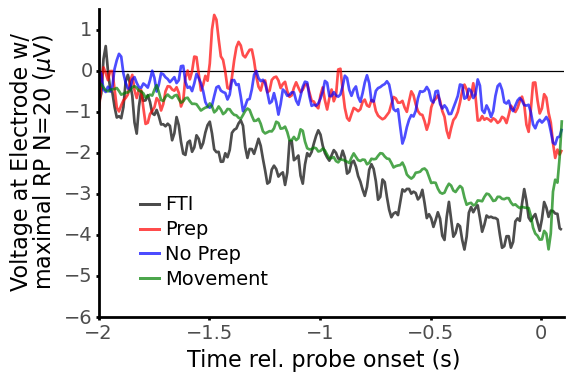

<ggplot: (172575174635)>

In [29]:
df_temp = df[['rp','subject','time','trial','condition']].groupby(['condition','time','subject'],as_index=False).mean().groupby(['condition','time'],as_index=False).mean()

df_temp = df_temp[~df_temp.condition.isin(['Unsure'])]
p=(ggplot(df_temp,aes(x='time',y='rp',color='condition')) +
  geom_hline(yintercept=0,linetype='-',color='black') +

geom_line(alpha=0.7,size=1.1) + 
 scale_x_continuous(name='Time rel. probe onset (s)',
                    breaks=np.arange(-2.5,1.6,0.5),
                    limits=(-2,0.1),
                    expand = (0,0)) +
   scale_y_continuous(name='Voltage at Electrode w/\nmaximal RP N=20 ($\mu$V)',
                      breaks=np.arange(-7,5,1),
                      limits=(-6,1.5),
                      expand = (0,0)) +
   scale_color_manual(name='Condition',values=['black','red','blue','green'],labels=['FTI','Prep','No Prep','Movement'])+
#    facet_wrap('~subject') +
    theme_classic() +
   theme(legend_position = (0.3,0.3),
         legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
#          strip_background=element_blank(),
#          subplots_adjust={'wspace':0.1,'hspace':0.3},
        figure_size = (6,4)) 
)

# p.save(savepath+'ERP/supp_rp_grandavg.svg')
# p.save(savepath+'ERP/supp_rp_grandavg.png')
p

### Using Cz and taking grand-average

C:\Users\j_gav\anaconda3\envs\pymer4\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 241 rows containing missing values.


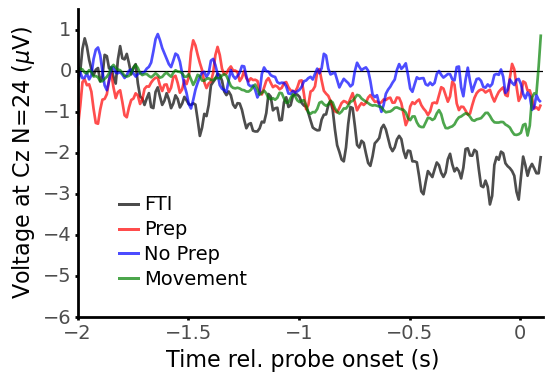

<ggplot: (172663302876)>

In [30]:
df_temp = df[['cz','subject','time','trial','condition']].groupby(['condition','time','subject'],as_index=False).mean().groupby(['condition','time'],as_index=False).mean()

df_temp = df_temp[~df_temp.condition.isin(['Unsure'])]
p=(ggplot(df_temp,aes(x='time',y='cz',color='condition')) +
  geom_hline(yintercept=0,linetype='-',color='black') +

geom_line(alpha=0.7,size=1.1) + 
 scale_x_continuous(name='Time rel. probe onset (s)',
                    breaks=np.arange(-2.5,1.6,0.5),
                    limits=(-2,0.1),
                    expand = (0,0)) +
   scale_y_continuous(name='Voltage at Cz N=24 ($\mu$V)',
                      breaks=np.arange(-7,5,1),
                      limits=(-6,1.5),
                      expand = (0,0)) +
   scale_color_manual(name='Condition',values=['black','red','blue','green'],labels=['FTI','Prep','No Prep','Movement'])+
#    facet_wrap('~subject') +
    theme_classic() +
   theme(legend_position = (0.3,0.3),
         legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=14),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         axis_line = element_line(size=2),
         axis_ticks_major = element_line(size=2),
#          strip_background=element_blank(),
#          subplots_adjust={'wspace':0.1,'hspace':0.3},
        figure_size = (6,4)) 
)

# p.save(savepath+'ERP/supp_cz_grandavg.svg')
# p.save(savepath+'ERP/supp_cz_grandavg.png')
p

### Unused -- beta traces over time at C3

script immediately below used for fitting, further below just plotting.

In [7]:
electrode = 'C3'
band = 'betaH'
elecband = electrode + '_' + band + '_base'

fti_mask = np.logical_or((df.fti_time.values <=0.2), (df.condition.isin(['RP','Hit','Miss'])))


df_temp = df[(fti_mask) & (~df.subject.isin([999]))]

frames = []
frames_sig = []
for time in df.time.unique():
    df_t = df_temp.loc[(df_temp.time == time) & (df_temp.condition.isin(['Hit','Miss','FTI','RP'])),[elecband,'condition','subject']]
    
    
    
    model = Lmer(elecband + ' ~ condition + (1|subject)',data=df_t.dropna())
    
    model.fit(factors = {'condition':['Hit','Miss','FTI','RP']},summary=False)
    
    
    marginal_estimates, comparisons = model.post_hoc(
        marginal_vars="condition",#, grouping_vars=["precueType"],
        p_adjust = "bonf"
    )
#     df_t = model.coefs.copy()
    df_t = marginal_estimates.copy()    
    
    df_t['time'] = time
    frames.append(df_t)
    
    df_t = comparisons.copy()
    df_t['time'] = time
    frames_sig.append(df_t)
    
    
df_CI = pd.concat(frames)
df_sig = pd.concat(frames_sig).reset_index()
df_CI = df_CI.reset_index()

df_CI = df_CI.rename(columns = {'2.5_ci':'ci_low','97.5_ci':'ci_high'})

P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
P-values adjusted by bonf method for 6 comparisons
boundary (singular) fit: see ?isSingular 

P-values adjusted by bonf method for 6 comparisons
boundary (singular) fit: see ?isSingular 

P-values adjusted by bonf method for 6 comparisons
boundary (singular) fit: see ?isSingular 

P-values adjusted by bonf method for 6 comparisons
boundary (singular) fit: see ?isSingular 

P-values adjusted by bonf method for 6 comparisons
boundary (singular) fit: see ?isSingular 

P-values adjusted by

In [8]:
if post:
    df_CI.to_csv('processed_data/'+elecband+'_CI_rebaselined.csv',index=False)
    df_sig.to_csv('processed_data/'+elecband+'_sig_rebaselined.csv',index=False)
else:
    df_CI.to_csv('processed_data/'+elecband+'_CI.csv',index=False)
    df_sig.to_csv('processed_data/'+elecband+'_sig.csv',index=False)

/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/C3_betaL_base_allconds_CI.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 191 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 7 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/C3_betaL_base_allconds_CI.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/pyth

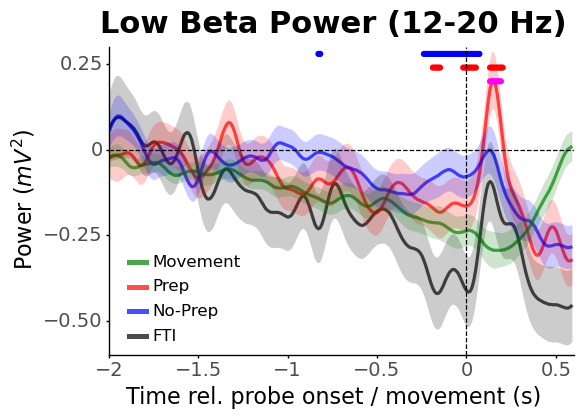

<ggplot: (455527750)>

In [20]:
electrode = 'C3'
band = 'betaL'
elecband = electrode + '_' + band + '_base'

titles = {'betaL':"Low Beta (12-20 Hz)",'betaH':"High Beta (20-30 Hz)"}

df_CI = pd.read_csv('processed_data/'+elecband+'_CI.csv')
df_sig = pd.read_csv('processed_data/'+elecband+'_sig.csv')

df_temp = df_CI.reset_index().copy()

df_temp = df_temp.rename(columns = {'Unnamed: 0':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

# df_temp = df_temp[df_temp.condition.isin(['conditionFTI','conditionMiss','conditionHit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values

df_tsig = df_sig.copy()

df_tsig['yintercept1'] = 0.2
df_tsig['yintercept2'] = 0.24
df_tsig['yintercept3'] = 0.28

df_tsig['sig'] = (df_tsig['P-val'].values < 0.3).astype('int') # 6 bonferroni post-hoc test correction = 0.05 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan
df_tsig['condition'] = np.nan


p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
geom_line(alpha=0.7,size=1.3) + 
    ggtitle("Low Beta Power (12-20 Hz)")+
   geom_ribbon(alpha=0.2,color='none',show_legend=False) +
   geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - Miss'])) & (df_tsig.sig == 1)],color='magenta',fill='magenta') +
   geom_point(aes(y = 'yintercept2'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - FTI'])) & (df_tsig.sig == 1)],color='red',fill='red') +
    geom_point(aes(y = 'yintercept3'),data = df_tsig[(df_tsig.Contrast.isin(['Miss - FTI'])) & (df_tsig.sig == 1)],color='blue',fill='blue') +

 scale_x_continuous(name='Time rel. probe onset / movement (s)',breaks=np.arange(-2.5,0.9,0.5),limits=(-2,0.6),expand = (0,0)) +
   scale_y_continuous(name='Power ($mV^2$)',breaks=np.arange(-0.5,0.5,0.25),limits=(-0.6,0.3),expand = (0,0)) +
   scale_color_manual(breaks = ['RP','Hit','Miss','FTI'],
                        labels = ['Movement','Prep','No-Prep','FTI'],
                      values=['green','red','blue','black'])+
   scale_fill_manual(breaks = ['RP','Hit','Miss','FTI'],values=['green','red','blue','black']) +
 theme_classic() +
   theme(legend_position=(0.25,0.25),
        legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=12),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         plot_title = element_text(size=22,face='bold'),
        figure_size = (6,4)) +
   geom_vline(xintercept=0,linetype='--',color='black') + 
   geom_hline(yintercept=0,linetype='--',color='black') 
)

p.save(savepath+'eeg/'+elecband+'_allconds_CI.svg')
p.save(savepath+'eeg/'+elecband+'_allconds_CI.png')

p

In [10]:
df_temp = df.loc[df.time.between(-0.25,0),['subject','trial','condition',elecband]].groupby(['subject','trial','condition'],as_index=False).mean()

df_temp.to_csv('processed_data/'+elecband+'_averages.csv',index=False)


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/C3_betaH_base_allconds_CI.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 191 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/C3_betaH_base_allconds_CI.png
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 191 rows containing missing values.
/Users/gavenas/opt/anaconda3/envs/pymer4

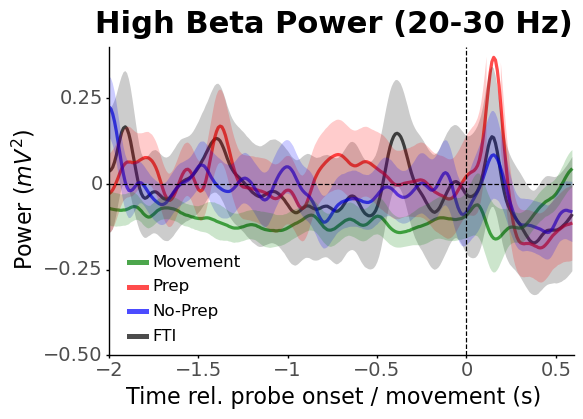

<ggplot: (454802119)>

In [24]:
electrode = 'C3'
band = 'betaH'
elecband = electrode + '_' + band + '_base'

titles = {'betaL':"Low Beta (12-20 Hz)",'betaH':"High Beta (20-30 Hz)"}

df_CI = pd.read_csv('processed_data/'+elecband+'_CI.csv')
df_sig = pd.read_csv('processed_data/'+elecband+'_sig.csv')

df_temp = df_CI.reset_index().copy()

df_temp = df_temp.rename(columns = {'Unnamed: 0':'condition','2.5_ci':'ci_low','97.5_ci':'ci_high'})

# df_temp = df_temp[df_temp.condition.isin(['conditionFTI','conditionMiss','conditionHit'])]

df_temp['ci_high'] = df_temp.Estimate.values + df_temp.SE.values
df_temp['ci_low'] = df_temp.Estimate.values - df_temp.SE.values

df_tsig = df_sig.copy()

df_tsig['yintercept1'] = 0.2
df_tsig['yintercept2'] = 0.24
df_tsig['yintercept3'] = 0.28

df_tsig['sig'] = (df_tsig['P-val'].values < 0.3).astype('int') # 6 bonferroni post-hoc test correction = 0.05 uncorrected

df_tsig['ci_low'] = np.nan
df_tsig['ci_high'] = np.nan
df_tsig['condition'] = np.nan


p=(ggplot(df_temp,aes(x='time',y='Estimate', ymin = 'ci_low',ymax = 'ci_high',color='condition',fill='condition')) +
geom_line(alpha=0.7,size=1.3) + 
    ggtitle("High Beta Power (20-30 Hz)")+
   geom_ribbon(alpha=0.2,color='none',show_legend=False) +
   geom_point(aes(y = 'yintercept1'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - Miss'])) & (df_tsig.sig == 1)],color='magenta',fill='magenta') +
   geom_point(aes(y = 'yintercept2'),data = df_tsig[(df_tsig.Contrast.isin(['Hit - FTI'])) & (df_tsig.sig == 1)],color='red',fill='red') +
    geom_point(aes(y = 'yintercept3'),data = df_tsig[(df_tsig.Contrast.isin(['Miss - FTI'])) & (df_tsig.sig == 1)],color='blue',fill='blue') +

 scale_x_continuous(name='Time rel. probe onset / movement (s)',breaks=np.arange(-2.5,0.9,0.5),limits=(-2,0.6),expand = (0,0)) +
   scale_y_continuous(name='Power ($mV^2$)',breaks=np.arange(-0.5,0.5,0.25),limits=(-0.5,0.4),expand = (0,0)) +
   scale_color_manual(breaks = ['RP','Hit','Miss','FTI'],
                        labels = ['Movement','Prep','No-Prep','FTI'],
                      values=['green','red','blue','black'])+
   scale_fill_manual(breaks = ['RP','Hit','Miss','FTI'],values=['green','red','blue','black']) +
 theme_classic() +
   theme(legend_position=(0.25,0.25),
        legend_title = element_blank(),
         legend_background = element_blank(),
         legend_text = element_text(size=12),
         axis_text = element_text(size=14),
       axis_ticks_length = 2,
       axis_title = element_text(size=16),
         plot_title = element_text(size=22,face='bold'),
        figure_size = (6,4)) +
   geom_vline(xintercept=0,linetype='--',color='black') + 
   geom_hline(yintercept=0,linetype='--',color='black') 
)

p.save(savepath+'eeg/'+elecband+'_allconds_CI.svg')
p.save(savepath+'eeg/'+elecband+'_allconds_CI.png')

p

In [ ]:
df_temp = df.loc[df.time.between(-0.25,0),['subject','trial','condition',elecband]].groupby(['subject','trial','condition'],as_index=False).mean()

df_temp.to_csv('processed_data/'+elecband+'_averages.csv',index=False)

In [ ]:
# Group according to subject & condition, average (mean) across 300 ms before movement
df_temp = df[(df.time >= -0.25) & (df.time <= 0.0) & (df.condition.isin(['Hit','Miss','FTI'])) & (~df.subject.isin([999]))].copy()
df_temp = df_temp.groupby(['subject','condition','trial'],as_index=False).mean()
df_temp['subject'] = df_temp.subject.astype('str')

# Set up model so that it is an effect of condition and a random intercept of subject
model = Lmer('rp ~ condition + (1|subject)',data=df_temp)

#     print(model.fit())
print(model.fit(factors={"condition":['Miss','Hit','FTI']}))


fig = plt.figure(figsize=(10,20))

model.plot_summary(plot_intercept=False)

# plt.savefig(savepath+'/lme_probe_eeg_pre.eps')

In [59]:
## Error Bars Only

model = Lmer('rp ~ 0 + condition + (1|subject)',data=df_temp)
#     print(model.fit())
print(model.fit(factors={"condition":['Miss','Hit','FTI']}))
marginal_estimates, comparisons = model.post_hoc(
        marginal_vars="condition"
    )

print(comparisons)
print(marginal_estimates)

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: rp~0+condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 1659	 Groups: {'subject': 20.0}

Log-likelihood: -4893.935 	 AIC: 9787.870

Random effects:

                 Name      Var    Std
subject   (Intercept)    4.882   2.21
Residual               103.024  10.15

No random effect correlations specified

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
conditionMiss    -0.622  -1.911    0.667  0.657  26.184  -0.946  0.353     
conditionHit     -1.102  -2.633    0.428  0.781  49.665  -1.412  0.164     
conditionFTI     -3.448  -4.980   -1.915  0.782  49.701  -4.409  0.000  ***
P-values adjusted by tukey method for family

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: rp~0+condition+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 1659	 Groups: {'subject': 20.0}

Log-likelihood: -4893.935 	 AIC: 9787.870

Random effects:

                 Name      Var    Std
subject   (Intercept)    4.882   2.21
Residual               103.024  10.15

No random effect correlations specified

Fixed effects:

               Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
conditionMiss    -0.622  -1.911    0.667  0.657  26.184  -0.946  0.353     
conditionHit     -1.102  -2.633    0.428  0.781  49.665  -1.412  0.164     
conditionFTI     -3.448  -4.980   -1.915  0.782  49.701  -4.409  0.000  ***


/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/LME_amplitudes_errbar.svg
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 4 in image.
/Users/gavenas/opt/anaconda3/envs/pymer4/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./figures_rough/ed2/eeg/LME_amplitudes_errbar.png


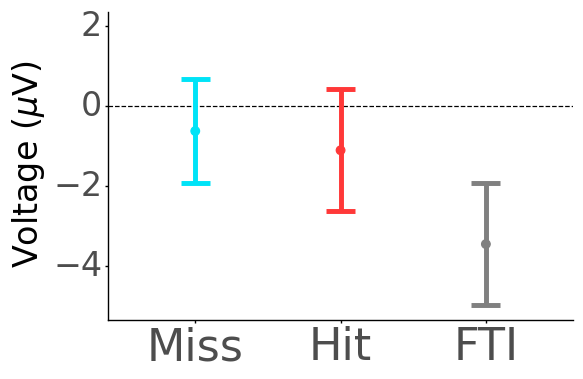

<ggplot: (445570386)>

In [14]:
df_lmeEst = pd.DataFrame({
    'condition':['Miss','Hit','FTI'],
    'rp':[model.coefs['Estimate'][0],model.coefs['Estimate'][1],model.coefs['Estimate'][2]],
    'CIlow':[model.coefs['2.5_ci'][0],model.coefs['2.5_ci'][1],model.coefs['2.5_ci'][2]],
    'CIhigh':[model.coefs['97.5_ci'][0],model.coefs['97.5_ci'][1],model.coefs['97.5_ci'][2]]
})

p = (ggplot(df_temp,aes(x='condition',y='rp',color='condition',fill='condition')) +
        geom_hline(yintercept=0,linetype='--',color='black') +

     scale_x_discrete(name='Condition',limits=['Miss','Hit','FTI']) +
     geom_errorbar(aes(y='rp',ymin='CIlow',ymax='CIhigh'),data=df_lmeEst,size=2,width=0.2) +
     geom_point(aes(y='rp'),data=df_lmeEst,size=3) +
#  scale_y_continuous(breaks=np.arange(-15,36,5),limits=(-15,38)) +
   scale_y_continuous(name='Voltage ($\mu$V)',limits=(-5,2)) +
   scale_color_manual(name='Condition',values=['gray','#FF3838','#00E3F7'])+
     scale_fill_manual(values=['gray','#FF3838','#00E3F7']) +
#  labs(title='Anticipatory Pupil Dilations') +
 theme_classic() +
   theme(legend_position='none',
        axis_text_y = element_text(size=24),
     axis_text_x = element_text(size=32),

       axis_ticks_length = 2,
       axis_title_y = element_text(size=24),
         axis_title_x = element_blank(),
        figure_size = (6,4)) 
)

p.save(savepath+'eeg/LME_amplitudes_errbar.svg')
p.save(savepath+'eeg/LME_amplitudes_errbar.png')

p